In [1]:
import numpy as np
import dataIO, common_functions
from sklearn import cross_validation, linear_model
reload(dataIO)
reload(common_functions)


def learn_offset(points, targets):
    regr = linear_model.LinearRegression()
    regr.fit(points, targets)
    
    return regr

locations, bod, targets_x, targets_y, y, touch_centers = dataIO.process_twohand(6)

locations = np.array(locations)
bod = np.array(bod)
targets_x = np.array(targets_x)
targets_y = np.array(targets_y)
y = np.array(y)
touch_centers = np.array(touch_centers)

print("MSE on x before regression: %.2f"  % np.mean(targets_x ** 2))
print("MSE on y before regression: %.2f"  % np.mean(targets_y ** 2))
within_before = common_functions.circle_button_error(locations, touch_centers)

foldno = 1
se_x = []
se_y = []
within_after = []
kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True)

for train_index, test_index in kf:
    
    points_train, points_test = locations[train_index], locations[test_index]
    t_x_train, t_x_test = targets_x[train_index], targets_x[test_index]
    t_y_train, t_y_test = targets_y[train_index], targets_y[test_index]
    y_train, y_test = y[train_index], y[test_index]
    centers_train, centers_test = touch_centers[train_index], touch_centers[test_index]
    
    regr_x = []
    regr_y = []
    
    for i in range(0,2):
        index = np.where(y_train==i)[0]
        regr_x.append(learn_offset(points_train[index], t_x_train[index]))
        regr_y.append(learn_offset(points_train[index], t_y_train[index]))
        
    new_points = []
    for i in range(len(points_test)):
        point = points_test[i]
        thumb = y_test[i]
        
        pred_x = regr_x[thumb].predict(point)
        pred_y = regr_y[thumb].predict(point)
        
        new_points.append([point[0]+pred_x, point[1]+pred_y])
     
    within_after.append(common_functions.circle_button_error(new_points, centers_test))
    new_points = np.array(new_points).T
    centers_test = centers_test.T
    
    se_x.append((new_points[0]-centers_test[0])**2)
    se_y.append((new_points[1]-centers_test[1])**2)
    
    foldno +=1    

se_x = np.array([item for sublist in se_x for item in sublist])
se_y = np.array([item for sublist in se_y for item in sublist])

print 
print("Mean MSE on x: %.2f" % np.mean(se_x))
print("Mean MSE on y: %.2f" % np.mean(se_y))      
within_after = np.mean(np.array(within_after), 0)
    

MSE on x before regression: 114.52
MSE on y before regression: 139.14

Mean MSE on x: 82.90
Mean MSE on y: 138.30


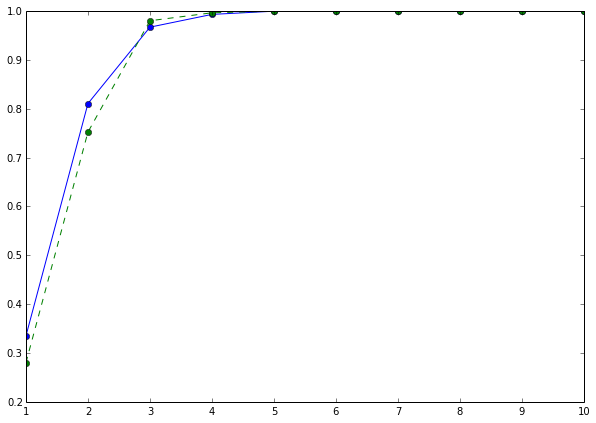

In [2]:
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

fig = plt.figure(figsize=(10, 7))

plt.errorbar(range(1,11), within_after, marker="o")
plt.errorbar(range(1,11), within_before, linestyle="--", marker="o")

plt.show()

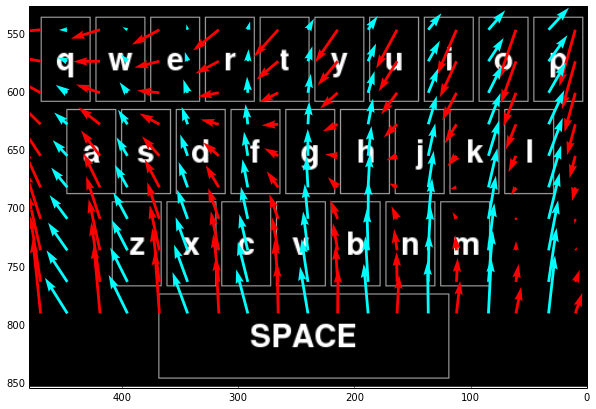

In [3]:
fig = plt.figure(figsize=(10, 7))

index = np.where(y==0)[0]
regr_l_x = learn_offset(locations[index], targets_x[index])
regr_l_y = learn_offset(locations[index], targets_y[index])

index = np.where(y==1)[0]
regr_r_x = learn_offset(locations[index], targets_x[index])
regr_r_y = learn_offset(locations[index], targets_y[index])

im = plt.imread("../../keyboard.png")
implot = plt.imshow(im, extent=[480, 0, 854, 526])

nx, ny = (10, 10)
y = np.linspace(10, 470, ny)
x = np.linspace(546, 790, nx)
xv, yv = np.meshgrid(x, y)
xy = np.reshape(np.dstack((xv, yv)), (nx*ny, 2))
xy_unz = zip(*xy)

pred_x = regr_l_x.predict(xy)
pred_y = regr_l_y.predict(xy)

plt.quiver(xy_unz[1], xy_unz[0], pred_y, pred_x, color='red', width = 0.005, angles='xy')

nx, ny = (10, 9)
y = np.linspace(33, 447, ny)
x = np.linspace(546, 790, nx)
xv, yv = np.meshgrid(x, y)
xy = np.reshape(np.dstack((xv, yv)), (nx*ny, 2))
xy_unz = zip(*xy)

pred_x = regr_r_x.predict(xy)
pred_y = regr_r_y.predict(xy)

plt.quiver(xy_unz[1], xy_unz[0], pred_y, pred_x, color='cyan', width = 0.005, angles='xy')

plt.show()